In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("data/technical/sales_train.csv")
feature_names = ['date_block_num', 'shop_id', 'item_id', 'item_price']
df_features = df_train[feature_names]
df_test = pd.read_csv("data/technical/test.csv")

In [3]:
mse = False  # set `True` for MSE, `False` for RMSE

# Check Correlation between the features

[Source for the formatting](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)

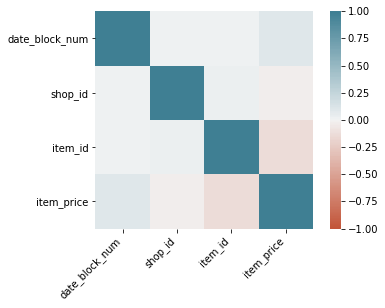

In [4]:
corr = df_features.corr()

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);  # the ';' suppresses the output

**Little to no correlation found between the features:**

`item_id` gives us a negative correlation, which is to be expected.

The only tiny correlation to be found is regarding the price of the item.
`item_price` shows the darkest spot on the graph.

Cite correlation interpretation: `978-1-4614-7138-7` - p. 156


# Boxplot: that a closer look at `item_price`

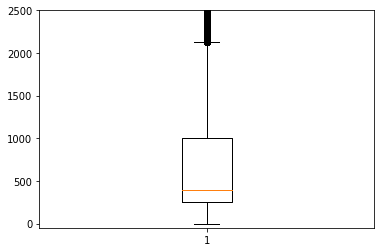

In [5]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_features['item_price'])
plt.ylim([-50, 2500])
plt.show()

Get a grip of the price at hand by converting it to a familiar currency.

In [6]:
from currency_converter import CurrencyConverter
from datetime import date

c = CurrencyConverter()

rub_in_usd = int(c.convert(500, 'RUB', 'USD', date=date(2014, 7, 1)))

print(f"500 RUB is approx. equal to {rub_in_usd} USD "
      f"at the time of the data.")


500 RUB is approx. equal to 14 USD at the time of the data.


# Linear regression

Start off with a simple application of a simple linear regression model

In [7]:
from sklearn.model_selection import train_test_split

X_test = df_test
Y_train = df_train['item_cnt_day']
X_train = df_train[feature_names]

x_train, x_test, y_train, y_test = train_test_split( X_train, Y_train, test_size=0.20, random_state=1)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()
LR.fit(x_train,y_train)

print('Train set rmse:', mean_squared_error(y_train, LR.predict(x_train), squared=mse))
print('Test set rmse:', mean_squared_error(y_test, LR.predict(x_test), squared=mse))
print('Test set score:', LR.score(x_train,y_train))

Train set rmse: 2.322206078154416
Test set rmse: 3.5639661191093497
Test set score: 0.0007086413604801001


The results do not look at all promising. Never use the test data during training.

Off to a new start.

In [9]:
# first, format the date to be regrouped into months

# transform to df date format
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
# convert date to month
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))

In [10]:
# parse all the months in the list to iterate them
# for later feature engineering

def col_is_year(col):
    return col[0] == '2'

def get_all_months(merged_frame):
    all_cols = set(merged_frame.columns.values.tolist())
    cols_to_remove = set()
    for col in all_cols:
        if not col_is_year(col):
            cols_to_remove.add(col)
    final_col = all_cols - cols_to_remove
    final_col = list(final_col)
    final_col.sort()
    return final_col

In [11]:
# then, sum up the sales according to their categories
df = df_train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)

all_months = get_all_months(df)

# join the remaining features to the newly created test dataframe
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test.drop(['ID'], axis=1, inplace=True)
df_test = df_test.fillna(0)

# assign train and test from within the train set
# drop october 2014 from the set and assign it was test values
drop_year = '2014-10'
X_test = df_test
Y_train = df[drop_year].values
X_train = df.drop([drop_year], axis=1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split( X_train, Y_train, test_size=0.20, random_state=1)

LR = LinearRegression()
LR.fit(x_train,y_train)


print('Train set rmse:', mean_squared_error(y_train, LR.predict(x_train), squared=mse))
print('Test set rmse:', mean_squared_error(y_test, LR.predict(x_test), squared=mse))
print('Test set score:', LR.score(x_train,y_train))

Train set rmse: 2.4113022745555877
Test set rmse: 2.0719456183279235
Test set score: 0.5540276005502269
